In [1]:
import networkx as nx
def pagerank_scipy(G, alpha=0.85, personalization=None,
                   max_iter=100, tol=1.0e-6, weight='weight',
                   dangling=None):
    """Return the PageRank of the nodes in the graph.

    PageRank computes a ranking of the nodes in the graph G based on
    the structure of the incoming links. It was originally designed as
    an algorithm to rank web pages.

    Parameters
    -----------
    G : graph
      A NetworkX graph.  Undirected graphs will be converted to a directed
      graph with two directed edges for each undirected edge.

    alpha : float, optional
      Damping parameter for PageRank, default=0.85.

    personalization: dict, optional
       The "personalization vector" consisting of a dictionary with a
       key for every graph node and nonzero personalization value for each
       node. By default, a uniform distribution is used.

    max_iter : integer, optional
      Maximum number of iterations in power method eigenvalue solver.

    tol : float, optional
      Error tolerance used to check convergence in power method solver.

    weight : key, optional
      Edge data key to use as weight.  If None weights are set to 1.

    dangling: dict, optional
      The outedges to be assigned to any "dangling" nodes, i.e., nodes without
      any outedges. The dict key is the node the outedge points to and the dict
      value is the weight of that outedge. By default, dangling nodes are given
      outedges according to the personalization vector (uniform if not
      specified) This must be selected to result in an irreducible transition
      matrix (see notes under google_matrix). It may be common to have the
      dangling dict to be the same as the personalization dict.

    Returns
    -------
    pagerank : dictionary
       Dictionary of nodes with PageRank as value

    Examples
    --------
    >>> G = nx.DiGraph(nx.path_graph(4))
    >>> pr = nx.pagerank_scipy(G, alpha=0.9)

    Notes
    -----
    The eigenvector calculation uses power iteration with a SciPy
    sparse matrix representation.

    This implementation works with Multi(Di)Graphs. For multigraphs the
    weight between two nodes is set to be the sum of all edge weights
    between those nodes.

    See Also
    --------
    pagerank, pagerank_numpy, google_matrix

    References
    ----------
    .. [1] A. Langville and C. Meyer,
       "A survey of eigenvector methods of web information retrieval."
       http://citeseer.ist.psu.edu/713792.html
    .. [2] Page, Lawrence; Brin, Sergey; Motwani, Rajeev and Winograd, Terry,
       The PageRank citation ranking: Bringing order to the Web. 1999
       http://dbpubs.stanford.edu:8090/pub/showDoc.Fulltext?lang=en&doc=1999-66&format=pdf
    """
    import scipy.sparse

    N = len(G)
    if N == 0:
        return {}

    nodelist = G.nodes()
    M = nx.to_scipy_sparse_matrix(G, nodelist=nodelist, weight=weight,
                                  dtype=float)
    S = scipy.array(M.sum(axis=1)).flatten()
    S[S != 0] = 1.0 / S[S != 0]
    Q = scipy.sparse.spdiags(S.T, 0, *M.shape, format='csr')
    M = Q * M

    # initial vector
    x = scipy.repeat(1.0 / N, N)

    # Personalization vector
    if personalization is None:
        p = scipy.repeat(1.0 / N, N)
    else:
        missing = set(nodelist) - set(personalization)
        if missing:
            raise NetworkXError('Personalization vector dictionary '
                                'must have a value for every node. '
                                'Missing nodes %s' % missing)
        p = scipy.array([personalization[n] for n in nodelist],
                        dtype=float)
        p = p / p.sum()

    # Dangling nodes
    if dangling is None:
        dangling_weights = p
    else:
        missing = set(nodelist) - set(dangling)
        if missing:
            raise NetworkXError('Dangling node dictionary '
                                'must have a value for every node. '
                                'Missing nodes %s' % missing)
        # Convert the dangling dictionary into an array in nodelist order
        dangling_weights = scipy.array([dangling[n] for n in nodelist],
                                       dtype=float)
        dangling_weights /= dangling_weights.sum()
    is_dangling = scipy.where(S == 0)[0]

    # power iteration: make up to max_iter iterations
    for _ in range(max_iter):
        xlast = x
        x = alpha * (x * M + sum(x[is_dangling]) * dangling_weights) + \
            (1 - alpha) * p
        # check convergence, l1 norm
        err = scipy.absolute(x - xlast).sum()
        if err < N * tol:
            return dict(zip(nodelist, map(float, x)))
    raise NetworkXError('pagerank_scipy: power iteration failed to converge '
                        'in %d iterations.' % max_iter)


In [2]:
import pickle
DG = pickle.load( open( '246_source/retweet_network_graph.p', "rb" ) )

In [8]:
Personalized_vector= DG.in_degree()
TrustSet = set([2,3,4])
NumberofTrust = len(TrustSet)
for key in Personalized_vector:
    if key in TrustSet:
        Personalized_vector[key] = 0
    else:
        Personalized_vector[key] = 1.0 / NumberofTrust


In [9]:
result = pagerank_scipy(DG,personalization=Personalized_vector)


KeyboardInterrupt: 

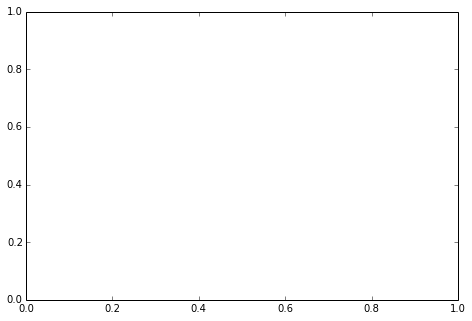

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
nx.draw(DG)
plt.show()

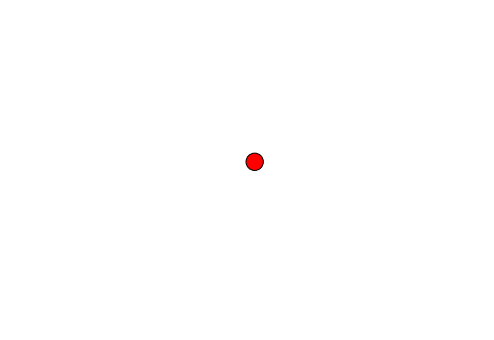

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
G = nx.DiGraph()
G.add_node(1)
nx.draw(G)
plt.show()